In [43]:
from pathlib import Path
import time
import torch
import numpy as np
import math
import pandas as pd
from dataset import LinearDynamicalDatasetNb
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
#import plotly.graph_objects as go
from transformer_sim import Config, TSTransformer
import tqdm
import argparse
import metrics

In [44]:
fig_path = Path("fig")
fig_path.mkdir(exist_ok=True)

In [45]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [46]:
# Overall settings
out_dir = "out"

# System settings
nu = 1
ny = 1
#seq_len = 600
batch_size = 256

# Compute settings
cuda_device = "cuda:0"
no_cuda = False
threads = 5
compile = True

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")

In [47]:
# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir/"ckpt_lin_sim_fix.pt", map_location="cpu")
cfg = exp_data["cfg"]

In [48]:
seq_len = cfg.seq_len_ctx + cfg.seq_len_new
nx = cfg.nx

In [49]:
model_args = exp_data["model_args"]
conf = Config(**model_args)
model = TSTransformer(conf).to(device)
model.load_state_dict(exp_data["model"]);

In [50]:
mdlargs = {"strictly_proper":True, "mag_range": (0.2, 0.99), "phase_range": (0, math.pi*3/4)} # distribution shift!
# mdlargs = {"strictly_proper":True, "mag_range": (0.5, 0.97), "phase_range": (0, math.pi/2)}
test_ds = LinearDynamicalDatasetNb(nx=cfg.nx, nu=cfg.nu, ny=cfg.ny, seq_len=cfg.seq_len_ctx+cfg.seq_len_new, system_seed=seed, **mdlargs)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=0)

In [51]:
batch_y, batch_u = next(iter(test_dl))
batch_y = batch_y.to(device)
batch_u = batch_u.to(device)
noise_std = 0.0
with torch.no_grad():
    batch_y_ctx = batch_y[:, :cfg.seq_len_ctx, :]
    batch_u_ctx = batch_u[:, :cfg.seq_len_ctx, :]
    batch_y_new = batch_y[:, cfg.seq_len_ctx:, :]
    batch_y_ctx = batch_y_ctx + torch.randn(batch_y_ctx.shape).to(device)*noise_std
    batch_u_new = batch_u[:, cfg.seq_len_ctx:, :]
    batch_y_sim = model(batch_y_ctx, batch_u_ctx, batch_u_new)

In [52]:
batch_y_sim = batch_y_sim.to("cpu").detach().numpy()
batch_y_new = batch_y_new.to("cpu").detach().numpy()
batch_u_new = batch_u_new.to("cpu").detach().numpy()
batch_sim_err = batch_y_new[:, :, :] - batch_y_sim[:, :, :]

In [53]:
t = np.arange(1, batch_u_new.shape[1]+1) + cfg.seq_len_ctx

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

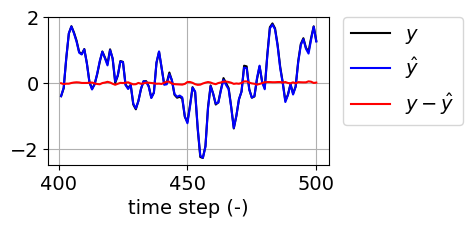

In [54]:
plt.figure(figsize=(5, 2.5))
idx = 10
plt.plot(t, batch_y_new[idx, :, :], 'k', label="$y$")
plt.plot(t, batch_y_sim[idx, :, :], 'b', label="$\hat y$")
plt.plot(t, batch_sim_err[idx, :, :], 'r', label="$y - \hat y$")
plt.grid(True)
plt.xlabel("time step (-)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig(fig_path / "lin_sim_single.pdf")

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

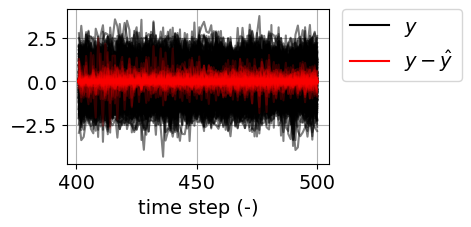

In [55]:
plt.figure(figsize=(5, 2.5))
#plt.ylim([-3, 3])
plt.plot(t, batch_y_new.squeeze(-1).T, "k", alpha=0.5);
plt.plot(t, np.nan*np.zeros(t.shape), "k", alpha=1.0, label="$y$")
plt.plot(t, batch_sim_err.squeeze(-1).T, "r", alpha=0.2);
plt.plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label="$y - \hat y$");
plt.grid(True)
plt.xlabel("time step (-)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig(fig_path / "lin_sim_batch.pdf")
#plt.plot(batch_pred_err.squeeze(-1).T, "m", alpha=0.5);

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

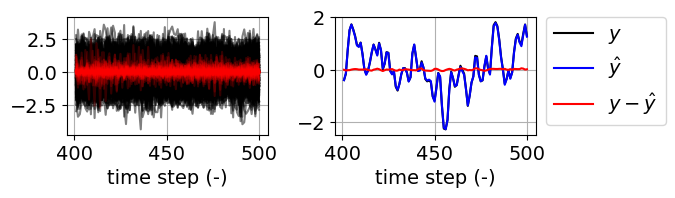

In [56]:
matplotlib.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica'], 'size': 14})
#matplotlib.rc('text', usetex=True)
matplotlib.rc('axes', grid=True)

fix, ax = plt.subplots(1,2, sharex=True, sharey=False, figsize=(7, 2.2))
ax[0].plot(t, batch_y_new.squeeze(-1).T, "k", alpha=0.5);
ax[0].plot(t, np.nan*np.zeros(t.shape), "k", alpha=1.0, label="$y$")
ax[0].plot(t, batch_sim_err.squeeze(-1).T, "r", alpha=0.2);
ax[0].plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label="$y-\hat y$")
ax[0].set_xlabel("time step (-)");

ax[1].plot(t, batch_y_new[idx, :, :], 'k', label="$y$")
ax[1].plot(t, batch_y_sim[idx, :, :], 'b', label="$\hat y$")
ax[1].plot(t, batch_sim_err[idx, :, :], 'r', label="$y - \hat y$")
ax[1].set_xlabel("time step (-)")
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig(fig_path / "wh_sim_batch_single.pdf")
plt.savefig(fig_path / "wh_sim_batch_single.png")

In [57]:
skip = 0
rmse = metrics.rmse(batch_y_new, batch_y_sim, time_axis=1)

In [58]:
n_param = sum(map(torch.numel, model.parameters()))
print(f'parameter count: {n_param}')
print(f'iterations: {exp_data["cfg"].max_iters}')
print(f'train_time: {exp_data["train_time"]/3600/24} days')
print(f'rmse: {rmse.mean()}')


parameter count: 5577729
iterations: 1000000
train_time: 0.9595808106329705 days
rmse: 0.06638180464506149


* no noise: 0.013 rmse
* 0.1 noise: 0.05 rmse
* 0.2 noise: 0.10 rmse
* 0.3 noise: 0.14 rmse
* 0.4 noise: 0.20 rmse
* 0.5 noise: 0.25 rmse

* with noise, distribution shift: 0.06 rmse

In [59]:
import scipy.io as sio

sio.savemat("lin_data.mat", {"batch_u": batch_u.to("cpu").numpy(), "batch_y": batch_y.to("cpu").numpy()})
